
# <center>Containers For Collaboration</center>
## <center>Using Docker to Share Your Software</center>

#### <center>Eric Kerfoot <eric.kerfoot@kcl.ac.uk>, School of Biomedical Engineering & Imaging Sciences, King's College London</center>
</center>

---

Complex software is becoming increasingly important in many areas of science, and part of the reproducibility of science is the dissemination of the software used. With more complex systems comes the challenge of constructing the correct environment to run this software by other scientists and collaborators. Anyone who's had to play with package managers for hours on end to get something to work knows how painful this can be!

This notebook is a short tutorial on using Docker to host a deep learning model in an image which includes all the environment and libraries needed for applying inference. The objective is to wrap a model into a portable and reproducible software unit your collaborators can easily download and invoke without having to worry about platform configuration beyond having Docker installed. 

Although the example in this notebook is a Pytorch-based network for segmenting the heart in 4D MR images, the concepts behind the creation of the Docker image and its use to perform inference can be applied to many other applications. **Many of the cells here contain code you can run to interact with Docker or perform the build process so feel free to use this notebook to experiment.**

We will cover:
1. What is Docker
2. Running Docker
3. Building Images
4. Model Inference
5. Sharing Your Image

## What is Docker?

Docker is a set of tools and applications to package software systems into portable deployable units called images. Containers represent running instances of images which rely on the libraries and environment contained in the image rather than that on the host system. Essentially a Docker image is a full Linux system minus the kernel and other low level components, configured however you like for your task at hand, and which relies only on the host kernel and drivers at runtime. 

By being self-contained images are much more portable units of software you can distribute to others easily. Challenges for workshops and conferences (such as those for MICCAI) sometimes require participants to submit their software as images so that the organizers can apply it to hidden test data. Specifically within the scientific field another common application area is cluster computing systems, where a user's job is submitted as an image which contains the setup and environment the job requires. This has advantages over systems which provide a set of libraries you can build your software against, but which can struggle to host new libraries you introduce to compile your software with. Containerization allows you to encapulate your software within a package the cluster can use with far fewer compatibility problems. 

<img style="float:right;width:400px;" src="./containers.png"/>

The most common alternative mechanism for encapsulating an entire environment is virtualization. Within a virtual machine, the "guest" operating system is presented with what appears to be the actual hardware of a running computer, but which in fact is a software environment provided by the "host". The guest must then provide all the facilities necessary to run an actual machine, including define a boot mechanism, format the necessary file systems, and provide a kernel along with the services necessary to interface with hardware. The figure at right illustrates this, comparing VMs against local applications and Docker containers.

By contrast Docker and other containerization schemes provide an abstraction at a higher level than a VM by using the host kernel and features it provides. This creates a lighter-weight environment and a smaller distribution file, as well as an easier interface between the guest and the host or other guest containers. By including nearly all the software infrastructure needed, a program hosted in a Docker image doesn't run afoul of a misconfigured system like a normal local program would. You as a user of the software do not have to set up libraries, dependencies, configurations, or otherwise install anything besides Docker to use the program.


#### Installation

Docker can be installed by following these instructions:

* **Linux**: Most of our workstations are Ubuntu so follow the instructions [here](https://docs.docker.com/engine/install/ubuntu). Other Linuces (Linuxes?) are [supported](https://docs.docker.com/engine/install/#server) but might be harder to trouble shoot.


* **Windows**: Instructions are [here](https://docs.docker.com/docker-for-windows/install). This should be a simple application installation, just be sure to [switch to Linux containers](https://docs.docker.com/docker-for-windows/#switch-between-windows-and-linux-containers).


* **macOS**: Instructions are [here](https://docs.docker.com/docker-for-mac/install). This should also be straight-forward.

## Running Docker

A Docker container can be instantiated with the `docker` command followed by arguments and the image tag name. Docker uses services called registries to store images, the default one Docker Hub (https://hub.docker.com/) which the `pull` command will look to when we request an image download:

In [1]:
!docker pull hello-world

Using default tag: latest
latest: Pulling from library/hello-world

bdcc26d7: Pull complete 529kB/2.529kBBDigest: sha256:49a1c8800c94df04e9658809b006fd8a686cab8028d33cfba2cc049724254202
Status: Downloaded newer image for hello-world:latest
docker.io/library/hello-world:latest


Run the above cell yourself to see command in action. With this downloaded we can now run the container with `run`:

In [2]:
!docker run hello-world


Hello from Docker!
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
    (amd64)
 3. The Docker daemon created a new container from that image which runs the
    executable that produces the output you are currently reading.
 4. The Docker daemon streamed that output to the Docker client, which sent it
    to your terminal.

To try something more ambitious, you can run an Ubuntu container with:
 $ docker run -it ubuntu bash

Share images, automate workflows, and more with a free Docker ID:
 https://hub.docker.com/

For more examples and ideas, visit:
 https://docs.docker.com/get-started/



We can see what images and containers we have using Docker commands:

In [28]:
!docker image ls

REPOSITORY          TAG                               IMAGE ID            CREATED             SIZE
python              3.7                               22c70bba8283        5 days ago          920MB
ubuntu              16.04                             c522ac0d6194        2 weeks ago         126MB
pytorch/pytorch     1.5.1-cuda10.1-cudnn7-runtime     d89e4943dd55        5 weeks ago         3.14GB
python              3.7-alpine                        6a5ca85ed89b        7 weeks ago         72.5MB
alpine              3.12                              a24bb4013296        8 weeks ago         5.57MB
hello-world         latest                            bf756fb1ae65        6 months ago        13.3kB
nvidia/cuda         10.1-cudnn7-runtime-ubuntu18.04   e135227729c4        7 months ago        1.65GB


In [27]:
!docker container ls -a

CONTAINER ID        IMAGE               COMMAND             CREATED             STATUS                     PORTS               NAMES
0a43be8cc32f        hello-world         "/hello"            4 seconds ago       Exited (0) 2 seconds ago                       adoring_sammet


For another example we can run the base Python 3.7 image (Jupyter cells don't like interactive terminals so I've put outputs here):
    
```sh
$ docker run -ti --rm python:3.7
```
```
Python 3.7.4 (default, Aug 14 2019, 12:09:51)
[GCC 8.3.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>>
```

This will download the image from Docker Hub then run it with the internal command specified, which is the python interactive shell. The arguments `-ti --rm` means allocate a pseudo-TTY, use interactive mode, and remove the container when it exits.

For this image we can provide a command to run instead of `python`, in this case `bash` to get a command prompt:

```sh
$ docker run -ti --rm python:3.7 bash
```
```
root@eca6d4b7f4ef:/# head -1 /etc/os-release 
PRETTY_NAME="Debian GNU/Linux 10 (buster)"
```

We can see that the Python image we're using is essentially a Debian 10 system internally, and with the `bash` command we can interact with it like it was a running Linux system. 

## Building Images

What we've seen so far is using Docker to instantiate containers from images and treat them like running programs. By containing the near entirety of a Linux system they don't require installation or configuration on the client side, so by making our own images we can package our own code into a unit we can hand out to collaborators and the general public. 

Docker images are built using a `Dockerfile` which is essentially a script file with special commands defining a recipe for creation. Typically an image is based off an initial existing one with added tweaks for a particular purpose. 

Let's create a Python-based "Hello, world" image based off the one we've already seen. Run the next four cells to create a working directory (generally good practice as Docker copies directories during building), a script file, the Dockerfile to go along with it, then to build and run it:

In [31]:
!mkdir hellopy

In [32]:
%%writefile hellopy/hello.py

print("Hello, world!")

Writing hellopy/hello.py


In [33]:
%%writefile hellopy/Dockerfile

FROM python:3.7
COPY hello.py /
CMD ["python","hello.py"]

Writing hellopy/Dockerfile


In [34]:
%%bash

cd hellopy
docker build . -t hellopy  # -t assigns the tag "hellopy" to the image
docker run --rm hellopy    # run the image tagged as "hellopy"

Sending build context to Docker daemon  3.072kB
Step 1/3 : FROM python:3.7
 ---> 22c70bba8283
Step 2/3 : COPY hello.py /
 ---> f83a218e13aa
Step 3/3 : CMD ["python","hello.py"]
 ---> Running in 183b7a43cd94
Removing intermediate container 183b7a43cd94
 ---> 4c79f534cadf
Successfully built 4c79f534cadf
Successfully tagged hellopy:latest
Hello, world!


The important aspects of what we've done here is in the Dockerfile. As said this is the recipe for putting a new image together, in this case we'll start with the `python:3.7` image (`FROM` line), copy the file `hello.py` in the current directory into the root of the image's file system which is distinct from the host's file system (`COPY` line), and then set the running command to `python hello.py` (`CMD` line). The previous cell's output has the message printed in the bottom.

We can instead run the image with a interactive terminal and state the program `bash` should be run:

```sh
$ docker run -ti --rm hellopy bash
root@d109519ef671:/#
```

Now the command on the `CMD` line gets replaced with whatever arguments we pass after the tag (ie. name) of the image. If we want to run a program or script in the container and be able to pass arguments to it, we need to use `ENTRYPOINT` in place of `CMD`. This forces that command to be run, and whatever is in `CMD` or given on the command line becomes arguments, we'll see why this is important shortly.

Dockerfiles can contain many other commands for doing other setup tasks. This notebook comes with another, `Docker_Cheatsheet.ipynb`, which contains more details on the common commands. The important one we'll be using later however is `RUN`, which runs a command in the image as if it were a running container. The state of the image after the command finishes is what the next `RUN` or other commands will work with, so this is used to run setup operations to configure the image how we like. What we get at the end is what we've built with these commands, and there are others that can be used to modify the environment in other ways.

## Model Inference

Included with this notebook is a Pytorch 1.5 neural network for segmenting the heart in MR images called `net.zip`. This is a UNet trained on the [ACDC dataset](https://www.creatis.insa-lyon.fr/Challenge/acdc/) to identify the left ventricle pool, left ventricular myocardium, and the right ventricle in the short axis orientation.

Also included is the script we'll be using to apply inference to a Nifti file called `seg_sax_3label.py`. This script will read the Nifti file passed on the command line (or through stdin if none given), apply inference using the network, then save the result to the supplied output filename (or to stdout if none given). You can run this script yourself now with the supplied `test.nii.gz` file generated from [the SCD dataset](https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/).

In [38]:
!python seg_sax_3label.py test.nii.gz -o out.nii

If we just give out this script and the network to collaborators, it's now up to them to configure their environments properly to run it, including installing the right version of Python, Pytorch, Nibabel, and other libraries. This isn't so trying with the magic of Python nowadays, but more complex software could be far more difficult to set up correctly. 

What we want to do now is create a Docker image which will do this setup for us, and which relies on the [Nvidia Container Toolkit](https://github.com/NVIDIA/nvidia-docker) to provide GPU acceleration. Our image must contain the network and script file but must also have Pytorch and Nibabel installed through Dockerfile commands. Run the following cells to create our segmentation image `seg_sax`:

In [39]:
%%bash
mkdir -p seg_sax  
cp net.zip seg_sax_3label.py seg_sax

In [40]:
%%writefile seg_sax/Dockerfile

FROM nvidia/cuda:10.1-cudnn7-runtime-ubuntu18.04

RUN apt-get update
RUN apt-get install python3-pip -y

RUN pip3 install torch==1.5.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
RUN pip3 install nibabel

COPY net.zip /
COPY seg_sax_3label.py /

ENTRYPOINT ["python3", "/seg_sax_3label.py"]

Overwriting seg_sax/Dockerfile


In [ ]:
%%bash
cd seg_sax
docker build . -t seg_sax

(Overly long output omitted)


#### File Redirection 
Now our image is built and stored locally. We've used the Nvidia CUDA image which is rather large but comes with all the libraries we need to use GPU acceleration. Now we can segment our Nifti file with IO redirection without having to install anything except Docker:

In [42]:
!docker run --gpus=all -i --rm seg_sax < test.nii.gz > out.nii

A few important things on what's going on here:
 * We're using IO redirection with the `<` and `>` operators to send the contents of `test.nii.gz` to stdin and stdout to `out.nii`. In our script if we don't have arguments for the input and output files the stdin/stdout streams are used instead.
 * We've selected to give access to all GPU devices with `--gpus=all`, without this CUDA will not be available when performing network inference. If we wanted to allow access to a specific card, eg. card 1, we would use an argument like `--gpus \"device=1\"`.
 * `-i` is used to run in interactive mode, without it stdin/stdout for the running container won't be connected to the terminal and so redirection wouldn't work.
 
Let's visualize some of our results. If you have Nibabel and Matplotlib installed you can run the following cell to see one segmented slice:

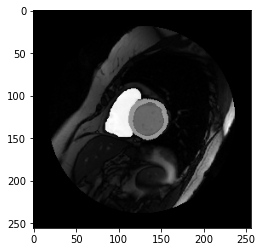

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt

im = nib.load('test.nii.gz').get_fdata()
seg = nib.load('out.nii').get_fdata()

idx = 10  # slice position

plt.imshow(im[..., idx, 0] / im.max() + seg[..., idx, 0] / 6, cmap='gray')

#### Direct File Access
The above use case for our image communicated with the container using file redirection. If we instead wanted to directly access files on the host file system we have to mount a virtual directory in the running container. Docker containers have a file system disjoint from the host file system for security and other reasons, other container technologies like Singularity don't do this. 

Mounting this virtual directory can be done through the `docker run` command:

In [50]:
!docker run --gpus=all --rm -u $(id -u ${USER}):$(id -g ${USER}) -v "$(pwd):/data:rw" seg_sax /data/test.nii.gz /data/out.nii

There's a lot going on here:
 * `-v "$(pwd):/data:rw"` states that we want to mount the current directory (the path to which is returned by the program `pwd`) and map it to `/data` in the container with read/write access.
 * `-u $(id -u ${USER}):$(id -g ${USER})` states that we want to run the container as the current user, the program `id` returns user and group ID numbers to do this. If we don't have this the container will run and produce files owned by `root` which isn't convenient, this way the files will be owned by you instead.
 * `/data/test.nii.gz /data/out_local.nii` are arguments to the script stating an input and an output file path, the script will read from paths when given instead of stdin/stdout. Note that these are paths to files *within* the running container, paths to files in your local file system will not be valid.
 * We don't need `-i` anymore.
 
Depending on what the task is it makes sense to use this method of accessing local files rather than the simpler file redirection, for our example segmentation image we can use either. 

## Sharing Your Image

With our image built and tested we now want to distribute it to collaborators and other scientists. We can export the image to a file and share that, but it'll be many gigabytes in size:

In [54]:
!docker save seg_sax | gzip > seg_sax.tgz
!du -h seg_sax.tgz

2.5G	seg_sax.tgz


This can be loaded with `docker load` into the local repository, but getting it to your users isn't convenient at 2.5GB. Instead we'll upload the image to Docker Hub, the registry service provided for Docker which we've been using to pull down images throughout this notebook. 

To do this first create an account with Docker Hub at https://hub.docker.com then use the `docker login` command to associate your local system with your account (replace "dockerid" with your Docker Hub account name):

```sh
$ docker login
```
```
Login with your Docker ID to push and pull images from Docker Hub. If you don't have a Docker ID, head over to https://hub.docker.com to create one.
Username: dockerid
Password:
WARNING! Your password will be stored unencrypted in /home/localuser/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store
```

Now we want to tag our image based on our docker ID and assign a tag "latest":

```sh
$ docker tag seg_sax dockerid/seg_sax:latest
```

Tags can be used to identify different types or versions of an image, latest is the commonly used one for referring to the most recent release. Finally we push to the registry:

```sh
$ docker push dockerid/seg_sax
The push refers to repository [docker.io/dockerid/seg_sax]
7ba0a45c6a59: ...
```

You should be able to see your image now at https://hub.docker.com/repository/docker/dockerid/seg_sax (replacing "dockerid" with your username of course). The free account with Docker Hub permits one repository to be private so if you want more you will have to sign up for a pro account, otherwise whatever else is uploaded is publicly available.

Now your collaborators can use your software just by specifying the full repository name of your image:

```sh
$ docker run --gpus=all -i --rm dockerid/seg_sax:latest < test.nii.gz > out.nii
```

As we've seen this will pull the image from Docker Hub and then run it. Your collaborators don't need anything more now besides the image name.


## That's It!

Now your model can be shared with other collaborators. We have used a Pytorch example with CUDA support in this notebook but of course any other program can be hosted in a Docker image with the right setup. Using the Nvidia images incurs an image size penalty so if speed isn't a priority you can change the Dockerfile to use a much smaller non-CUDA-compatible base image such as Alpine. 

Web services are a very common use case for Docker which present an application through a network interface, eg. databases. With Python frameworks like Flask you can put together simple web servers to provide functionality over your internal network, instead of just locally on the command line (or better yet use tools like [BentoML](https://bentoml.org/)). 

Graphical applications using X windowing (which everything in Linux does) can also be provided through Docker with command line options to forward the proper information so the program can find your display. Using the X servers available for macOS and Windows it's even possible to distribute such applications to any user though with a bit more setup on their side.

There are a huge array of possibilities for packaging up software systems with Docker. Reproducibility relies on the availability of all the tools used to conduct research, so with this technology you can now create modular and portable software units other users can easily employ themselves.

**Where to go from here?** Check out the included Docker cheatsheet for links and more information on the commands.

Thanks for reading!